# Quantum Instance Selection - Example

In this notebook we carry out an example of the Instance Selection at QuantumCLEF 2025. In particular, our aim is to draw a sample from a dataset that is composed of representative samples to avoid redundancy. This subset is then used to fine-tune a LLM in a more efficient way while preserving effectiveness.

We first create an example of the dataset. This will be a dataset composed of 5 classes with a total number of 500 points drawn from a 2D space for simplicity and ease of visualization. However, these points could represent document embeddings. In your case, the task will be to carry out instance selection on document embeddings.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from collections import defaultdict
import random


random_state=0

random.seed(random_state)

num_points = 500
num_classes = 5

# Creating our dataset of 500 2D points belonging to 5 classes
X, y = make_blobs(n_samples=num_points, centers=num_classes, n_features=2,
                  random_state=random_state)

We proceed by plotting the dataset to visualize the points in the 2D space.

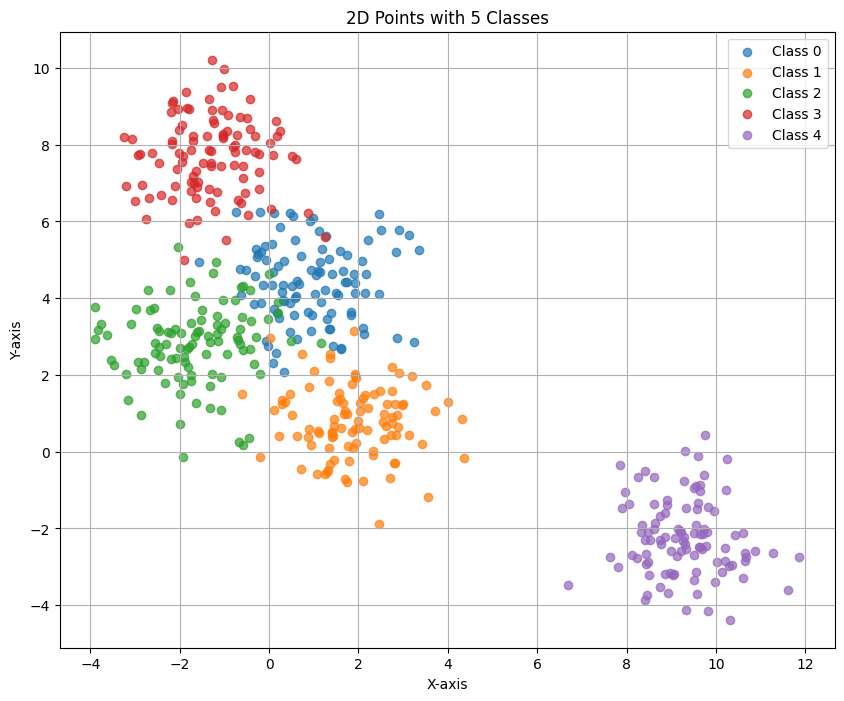

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', alpha=0.7)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Points with 5 Classes')
plt.legend()
plt.grid(True)
plt.show()

To work with quantum annealers, we need to formulate our problem as a QUBO problem. This involves transforming our problem into an objective function with at most quadratic terms and binary variables while avoiding the usage of hard constraints.

In our case, we want to formulate the problem to avoid redundancy while keeping the hard-to-classify samples. Given a dataset of $n$ points $P$, we proceed to formulate the QUBO matrix $\mathbf{Q} \in n \times n$ as follows:

 \begin{equation}
     \mathbf{Q}_{ij} =
    \begin{cases}
      -\text{distance}(p_i,p_j)  & \text{if } \text{label}(i) = \text{label}(j) \text{ and } i \neq j \\[8pt]
      \text{distance}(p_i,p_j)  & \text{if } \text{label}(i) \neq \text{label}(j) \text{ and } i \neq j \\[8pt]
      \frac{\displaystyle\sum\limits_{\substack{p \in P : \\ \text{label}(p) = \text{label}(p_i)}} 1}{|P|} & \text{if } i = j
    \end{cases}
\end{equation}

Let's break it down into its 3 parts:


1.   Intuitively, we want to keep points belonging to the same class if they are far apart from the other points of that class. This might help avoiding redundancy in the final subset of points. Since it is a minimization problems, we want to preserve points belonging to the same class that are more distant one from the other (see the minus sign)
2.   Intuitively, if two points of two different classes are very close, they probably represent hard-to-classify instances. In fact, they lie close to the classification border. We would like to keep them to help the model focusing on the small differences that can be important to define better the classification borders
3.   If one class has way many points with respect to the others, we want to select a lower percentage of samples from that class to try to fix the class unbalancing issue. This is done in the diagonal part of the QUBO matrix.


In [ ]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Create the QUBO matrix
Q = defaultdict(float)
class_counts = defaultdict(int)

for i in range(num_points):
    class_counts[y[i]] += 1

for i in range(num_points):
    for j in range(i, num_points):  # Iterate through upper triangle

        if i == j:
            Q[(i, i)] = class_counts[y[i]] / num_points  #diagonal terms
        else:
            distance = calculate_distance(X[i], X[j])

            # off-diagonal terms
            Q[(i,j)] = - distance
            Q[(j,i)] = - distance
            if(y[i]!=y[j]):
                Q[(i,j)] = distance
                Q[(j,i)] = distance

We proceed to create format our QUBO matrix as requested by the D-Wave APIs. In particular, we create a BQM (it is the equivalent of a QUBO problem but in another format). Then, since we want to keep a given number of samples of our dataset (e.g., 50% of the points), we need to try to enforce this as a penalty: all the solutions containing more or less than exactly 50% of the points will be penalized. This makes their associated value in the objective function much worse and, thus, they are very unlikely to be found by the solvers.

In [ ]:
import dimod
import neal
from dimod import BinaryQuadraticModel

bqm=BinaryQuadraticModel.from_qubo(Q)

penalty = bqm.maximum_energy_delta()

percentage=0.5

combination_bqm = dimod.generators.combinations(bqm.variables, int(percentage*num_points), strength=penalty)
bqm.update(combination_bqm)

We instantiate a sampler for the problem. In this case it is a SimulatedAnnealing sampler. In fact, to work with real quantum annealers, you should be careful! The size of this dataset does not fit in the QPU of quantum annealers. Thus you must find a way to split it into smaller subsets and to combine the achieved solutions or find another possible way to represent the problem such that the number of variables is lower (typically less than 150). 

Please, remember every time you want to solve a problem using our qclef package, you must report a correct label. It must be a label starting with the number of the task and then a custom text that represents your problem. In this case, it must be in the format **2[YourText]**.

In [ ]:
from qclef import qa_access as qa

sampler = SimulatedAnnealingSampler()
num_reads = 2000

sampleset=qa.submit(sampler,
    SimulatedAnnealingSampler.sample,
    bqm,
    label='2 - Instance Selection',
    num_reads=num_reads
)
print(sampleset.first.energy)

233464.4645037204


In [ ]:
print(sampleset)

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 499        energy num_oc.
10  0  1  1  1  1  0  1  0  1  1  1  0  0  0  0 ...   1 233464.464504       1
3   1  1  1  1  1  0  1  1  1  0  0  1  1  0  0 ...   1 236091.962502       1
19  0  1  1  0  1  0  0  0  1  1  1  0  1  1  0 ...   0 236249.205964       1
62  0  1  0  1  1  0  1  0  0  1  1  1  1  0  0 ...   1 237754.544297       1
27  0  1  0  1  0  0  1  0  1  0  1  0  1  0  1 ...   1 237912.020495       1
12  0  1  0  1  0  0  0  1  0  0  1  1  1  1  0 ...   1 241944.160098       1
34  1  1  1  1  0  0  1  0  1  1  1  1  0  1  1 ...   1  242871.98614       1
40  0  0  1  1  1  0  1  0  1  1  1  0  1  0  1 ...   1 243467.645126       1
56  1  1  0  1  1  0  0  0  0  0  0  1  0  0  0 ...   0 243626.182597       1
58  0  1  1  0  1  0  0  0  1  1  1  1  1  1  1 ...   1 244270.319458       1
50  1  1  1  1  1  0  1  0  1  0  0  1  0  1  0 ...   0 244381.637136       1
48  1  0  1  1  1  0  0  0  0  1  1  0  1  1  0 ...   1  244431.

After keeping the best sample among the ones retrieved using the Simulated Annealing solver (i.e., the sample associated with the lowest energy level), we plot the new dataset with respect to the old one.

250


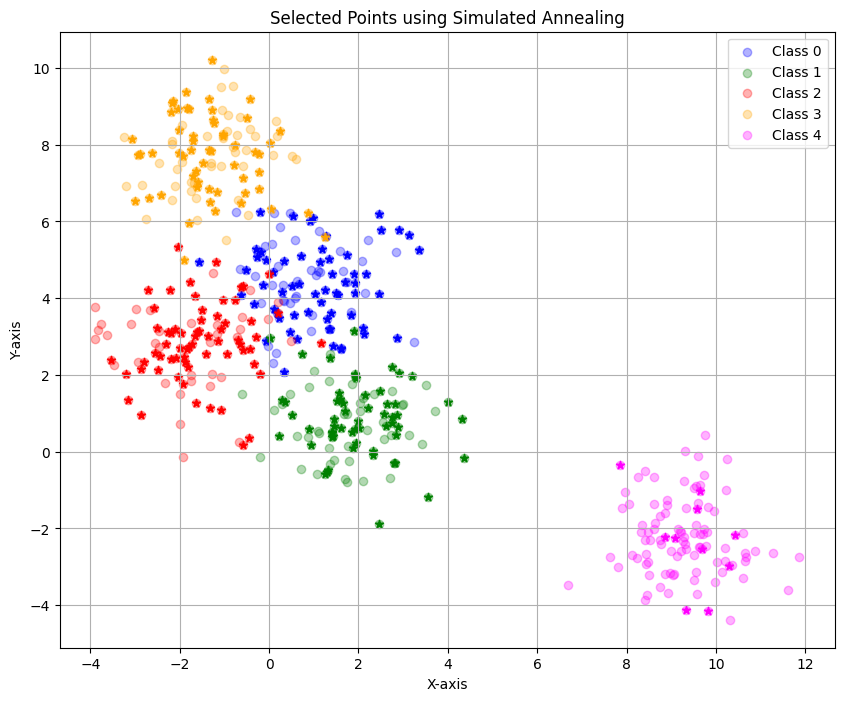

In [ ]:
best_sample = sampleset.first.sample
selected_points = [i for i, value in best_sample.items() if value == 1]

print(len(selected_points))

colors = ['blue', 'green', 'red', 'orange', 'magenta']

# Plot the selected points
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    # Original points with lower alpha
    plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', alpha=0.3, color=colors[i])

    # Selected points with higher alpha and the same color
    plt.scatter(X[(y == i) & (np.isin(np.arange(num_points), selected_points)), 0],
                X[(y == i) & (np.isin(np.arange(num_points), selected_points)), 1],
                alpha=1, color=colors[i],marker='*')  # Use the same color

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Selected Points using Simulated Annealing')
plt.legend()
plt.grid(True)
plt.show()

## What you are expected to do

You should carry out a similar task using the dataset that we provided you. This dataset contains document embeddings that represent your points in the space. You need to select a subset of these document embeddings, save the ids, and provide them in according to the submission format.

Your expected contribution is the design of the objective function to optimize and, at the same time, your ability of making the problem fit in the available QPU (e.g., by splitting it into subproblems).

In the dataset folder, for this Task you will find 2 datasets. Each dataset is split into 5 folds. You are given both the raw texts for each document and their embedding versions. For each fold, you should extract a subset of documents that is representative of the whole fold so that when used to fine-tune a Transformer-based model it will be able to retain its effectiveness.

In [ ]:
dataset = # Reading the dataset
filename="/submissions/feature_selection.txt" # Please, follow the file name format provided in the task description: [Dataset]_[FoldNumber]_[Method]_[Groupname]_[SubmissionID].txt . 
# Note that the SubmissionID is not the one reported in the last line of this cell. It is a custom ID that you give to represent your submission.
# For example, if you decide to use a method called 'AlgorithmX', you can give as SubmissionID your 'AlgorithmX'. The same 'AlgorithmX' must be used for both
# quantum and traditional submissions for comparison.


sampleset=qa.submit(EmbeddingComposite(DWaveSampler()), EmbeddingComposite.sample, bqm, label='2 Your Label', num_reads=100 ) # Please, do the same for Simulated Annealing as well for comparison.

solution=sampleset.first.sample 
docs_to_keep=[] 
for doc,selected in best_solution.items(): 
    if(selected==1): 
        docs_to_keep.append(doc) 

submission="" 
for i,doc in enumerate(docs_to_keep): 
    submission+=str(doc)+"\n" 
    
ids=[sampleset.info['problem_id']] # The ids can be retrieved also from your dashboard. These should be reported in the last line of your submission file as a list of ids.
submission+=str(ids)
